In [1]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
from pathlib import Path

path = str(Path().resolve())
path = path + "\\ADNI_PROCESSED"

def apply_mask(img_n_mmni, img_mask):
    """
        Taking a n_mmni and apply the correspondant mask
        param:
            img_n_mmi   : image n_mmi
            img_mask    : mask
    """
    mmni_m = img_n_mmni.get_fdata()
    mask_m = img_mask.get_fdata().astype(bool)
    mask_bg = np.logical_not(mask_m)
    mmni_m[mask_bg] = 0
    return mmni_m

def process_irm_data():
    """
        Create a new directory and process all images from tha ADNI1 directory
    """
    path = str(Path().resolve())
    path_res = path + "\\ADNI_PROCESSED"
    Path(path_res).mkdir(parents=True, exist_ok=True) # Create a directory for data processed
    path = path + "\\ADNI1"
    for filename in os.listdir(path):
        if filename.startswith("n_mmni"):
            n_mmni_filename = os.path.join(path, filename)
            mask_filename = os.path.join(path, "mask_" + filename)
            img_n_mmni = nib.load(n_mmni_filename)
            img_mask = nib.load(mask_filename)
            n_mmni_mask = apply_mask(img_n_mmni, img_mask)
            img = nib.Nifti1Image(n_mmni_mask, np.eye(4))
            nib.save(img, os.path.join(path_res, filename))

In [2]:
def cut_2D_i(img_n_mmni, axe, idx):
    """
        Function that returns a 2D cut from the "img" in the index "idx", along the axe given in parameter
    """
    axe_dim = {"x": img_n_mmni.shape[0], "y": img_n_mmni.shape[1], "z":img_n_mmni.shape[2]}
    if axe_dim[axe] <= idx or idx < 0:
        print("Invalid value for index must be between 0 and " , axe_dim[axe])
        return
    if axe == "x":
        cropped_img = img_n_mmni.slicer[idx:idx+1, 18:199, :]
        img_data = cropped_img.get_fdata()
        img_data = np.transpose(img_data, (2, 1, 0)) / 255.0
        img_data = np.transpose(img_data, (1, 0, 2)) / 255.0
    elif axe == "y":
        cropped_img = img_n_mmni.slicer[45:145, idx:idx+1,35:135] #eliminate black borders
        img_data = cropped_img.get_fdata()
        img_data = np.transpose(img_data, (0, 2, 1)) / 255.0
    elif axe == "z":
        cropped_img = img_n_mmni.slicer[..., idx:idx+1]
        img_data = cropped_img.get_fdata()
    else:
        print("Choose a valid value for axe: x, y or z")

    return img_data

def custom_patch_3D(img_n_mmni, x_tup, y_tup, z_tup):
    axe_dim = {"x": img_n_mmni.shape[0], "y": img_n_mmni.shape[1], "z":img_n_mmni.shape[2]}
    if axe_dim["x"] <= x_tup[1] or x_tup[0] < 0 or axe_dim["y"] <= y_tup[1] or y_tup[0] < 0 or axe_dim["z"] <= z_tup[1] or z_tup[0] < 0 :
        print("Invalid values")
        return 
    else:
        cropped_img = img_n_mmni.slicer[x_tup[0]:x_tup[1], y_tup[0]:y_tup[1], z_tup[0]:z_tup[1]]
        img_data = cropped_img.get_fdata()
        img_data.resize(img_data.shape + (1, ))
        return img_data

In [ ]:
import os
import re
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

def load_data(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[(data.Group == 'CN') | (data.Group == 'AD')]
    return data

path = str(Path().resolve())
path = path + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = load_data(path)
y_data.head(7)

In [ ]:
from tensorflow.keras.utils import to_categorical

usecols = ['Subject ID', 'Rooster ID', 'Group']
# ['CN', 'AD']
def prepare_X_of_Y(Y):
    X_data = []
    Y_data = []
    X_test_index = []
    Y_test = []
    path = str(Path().resolve())
    path += "\\ADNI_PROCESSED"
    n_test_AD = 0
    n_test_CN = 0
    for index, row in Y.iterrows():
        file = path + '\\n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        if os.path.isfile(file):
            img_n_mmni = nib.load(file)
            # Taking 4 images for test purpose
            if (Y['Group'][index] == 'AD' and n_test_AD < 2) or (Y['Group'][index] == 'CN' and n_test_CN < 2):
                n_test_AD += 1 if Y['Group'][index] == 'AD' else n_test_AD
                n_test_CN += 1 if Y['Group'][index] == 'CN' else n_test_CN
                X_test_index.append(index)
            else:
                for i in range(81, 86):
                    img_data = cut_2D_i(img_n_mmni, 'z', i)
                    X_data.append(img_data)
                    if Y['Group'][index] == 'AD':
                        Y_data.append(1)
                    elif Y['Group'][index] == 'CN':
                        Y_data.append(0)
        else:
            Y.drop(index, inplace=True)
    return np.array(X_data), Y_data, X_test_index

if os.path.isfile('X_data.npy') and os.path.isfile('Y_data.npy') and os.path.isfile('X_test_index.npy'):
    X_data = np.load('X_data.npy')
    Y_data = np.load('Y_data.npy')
    X_test_index = np.load('X_test_index.npy')
else:
    X_data, Y_data_list, X_test_index = prepare_X_of_Y(y_data)
    Y_data = to_categorical(Y_data_list, num_classes=2)
    np.save('X_data', X_data)
    np.save('Y_data', Y_data)
    np.save('X_test_index', X_test_index)
    
print(len(X_data) == len(Y_data))
print(len(X_data))

In [ ]:
from tensorflow.keras.utils import to_categorical

usecols = ['Subject ID', 'Rooster ID', 'Group']
# ['CN', 'AD']
def prepare_X_of_Y_3D(Y):
    X_data = []
    Y_data = []
    X_test_index = []
    Y_test = []
    path = str(Path().resolve())
    path += "\\ADNI_PROCESSED"
    n_test_AD = 0
    n_test_CN = 0
    for index, row in Y.iterrows():
        file = path + '\\n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        if os.path.isfile(file):
            img_n_mmni = nib.load(file)
            # Taking 4 images for test purpose
            if (Y['Group'][index] == 'AD' and n_test_AD < 2) or (Y['Group'][index] == 'CN' and n_test_CN < 2):
                n_test_AD += 1 if Y['Group'][index] == 'AD' else n_test_AD
                n_test_CN += 1 if Y['Group'][index] == 'CN' else n_test_CN
                X_test_index.append(index)
            else:
                img_data = custom_patch_3D(img_n_mmni, x_tup=(63, 123), y_tup=(90, 105), z_tup=(50, 110))
                X_data.append(img_data)
                if Y['Group'][index] == 'AD':
                    Y_data.append(1)
                elif Y['Group'][index] == 'CN':
                    Y_data.append(0)
        else:
            Y.drop(index, inplace=True)
    return np.array(X_data), Y_data, X_test_index

if os.path.isfile('X_data_3D.npy') and os.path.isfile('Y_data_3D.npy') and os.path.isfile('X_test_index_3D.npy'):
    X_data_3D = np.load('X_data_3D.npy')
    Y_data_3D = np.load('Y_data_3D.npy')
    X_test_index_3D = np.load('X_test_index_3D.npy')
else:
    X_data_3D, Y_data_list_3D, X_test_index_3D = prepare_X_of_Y_3D(y_data)
    Y_data_3D = to_categorical(Y_data_list_3D, num_classes=2)
    np.save('X_data_3D', X_data_3D)
    np.save('Y_data_3D', Y_data_3D)
    np.save('X_test_index_3D', X_test_index_3D)
    
print(len(X_data_3D) == len(Y_data_3D))

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

X_data = np.load('/kaggle/input/adni-data/X_data.npy')
Y_data = np.load('/kaggle/input/adni-data/Y_data.npy')
X_test_index = np.load('/kaggle/input/adni-data/X_test_index.npy')

#X_data_3D = np.load('/kaggle/input/adni-data/X_data_3D.npy')
#Y_data_3D = np.load('/kaggle/input/adni-data/Y_data_3D.npy')
#X_test_index_3D = np.load('/kaggle/input/adni-data/X_test_index_3D.npy')

print(len(X_data) == len(Y_data))
print(len(X_data))

True
2075


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{0: 'CN', 1: 'AD'}


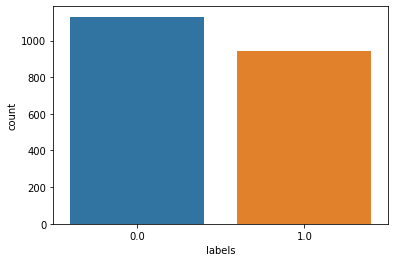

In [4]:
map_characters = {0: 'CN', 1: 'AD'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"] = Y_data[:,1]
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

## Loss visualization function
This function is used to visualize the variations of loss, val_loss, accuracy and val_accuracy over epochs. It is used for 3D and 2D models. 

In [5]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
      """
      Returns separate loss curves for training and validation metrics.
      """ 
      loss = history.history['loss']
      val_loss = history.history['val_loss']

      accuracy = history.history['accuracy']
      val_accuracy = history.history['val_accuracy']

      epochs = range(len(history.history['loss']))

      # Plot loss
      plt.plot(epochs, loss, label='training_loss')
      plt.plot(epochs, val_loss, label='val_loss')
      plt.title('Loss')
      plt.xlabel('Epochs')
      plt.legend()

      # Plot accuracy
      plt.figure()
      plt.plot(epochs, accuracy, label='training_accuracy')
      plt.plot(epochs, val_accuracy, label='val_accuracy')
      plt.title('Accuracy')
      plt.xlabel('Epochs')
      plt.legend()
      plt.savefig('accuracy.png')

# U-Net Neural Network

Creation of two U-Net models:
* One for 2D inputs, in case we slice the input into 2D images.
* The other for 3D inputs, in case we use 3D blocs of the image.

### 2D implementation of classification model
- Creation of an auto-encoder model and an only encoder model.
- compilation of the model using adam optimizer, and binary_crossentropy loss.
- fiting the model using GPU if it exists.

In [6]:
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, Cropping2D, Conv3D, MaxPooling3D, UpSampling3D, Cropping3D, Input, concatenate, Flatten, Dense, Dropout, BatchNormalization, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling3D, add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def create_Unet_model2D_encoder(input_size, depth=5, padding='same', nb_class=2):
    inputs = Input(shape=input_size)
    x = inputs
    num_filters = 64
    for i in range(depth):
        x = SeparableConv2D(filters=num_filters, kernel_size=(3,3), padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        x = SeparableConv2D(filters=num_filters, kernel_size=(3,3), padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        if i != depth - 1:
            x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
            num_filters *= 2

    # Flattenting
    # x = GlobalAveragePooling2D()(x)
    
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    # x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)
    
    
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(nb_class, activation='softmax')(x)

    return Model(inputs, outputs)

In [7]:
from tensorflow.keras.optimizers import Adam

model_2 = create_Unet_model2D_encoder(X_data[0].shape, depth=5)
model_2.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()

2021-12-02 19:39:43.958625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 19:39:44.067805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 19:39:44.068538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 19:39:44.069866: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 181, 217, 1)]     0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 181, 217, 64)      137       
_________________________________________________________________
batch_normalization (BatchNo (None, 181, 217, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 181, 217, 64)      0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 181, 217, 64)      4736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 181, 217, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 181, 217, 64)      0     

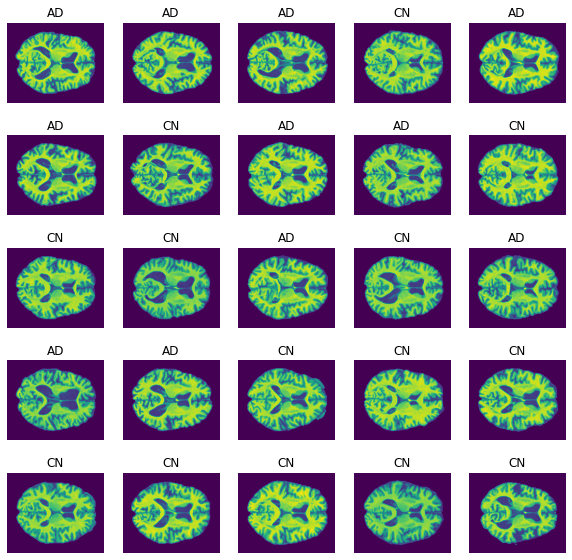

In [8]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2,random_state=42)

def show_batch(image_batch, label_X):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_X[n][1]:
            plt.title("AD")
        else:
            plt.title("CN")
        plt.axis("off")
show_batch(X_train, Y_train)

In [9]:
history = model_2.fit(X_train, Y_train, epochs=40, validation_data=(X_test, Y_test))

2021-12-02 19:39:58.471309: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2021-12-02 19:40:01.993382: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


52/52 [==============================] - 34s 463ms/step - loss: 0.7894 - accuracy: 0.6446 - val_loss: 0.8661 - val_accuracy: 0.5205
Epoch 2/40
52/52 [==============================] - 23s 434ms/step - loss: 0.6195 - accuracy: 0.7452 - val_loss: 1.2835 - val_accuracy: 0.5205
Epoch 3/40
52/52 [==============================] - 23s 435ms/step - loss: 0.4790 - accuracy: 0.8398 - val_loss: 1.4940 - val_accuracy: 0.5205
Epoch 4/40
52/52 [==============================] - 23s 434ms/step - loss: 0.3933 - accuracy: 0.8831 - val_loss: 1.6272 - val_accuracy: 0.5205
Epoch 5/40
52/52 [==============================] - 23s 434ms/step - loss: 0.3056 - accuracy: 0.9337 - val_loss: 1.4293 - val_accuracy: 0.5205
Epoch 6/40
52/52 [==============================] - 23s 435ms/step - loss: 0.2408 - accuracy: 0.9524 - val_loss: 1.3940 - val_accuracy: 0.5205
Epoch 7/40
52/52 [==============================] - 23s 435ms/step - loss: 0.1931 - accuracy: 0.9729 - val_loss: 1.4101 - val_accuracy: 0.5205
Epoch 8/40

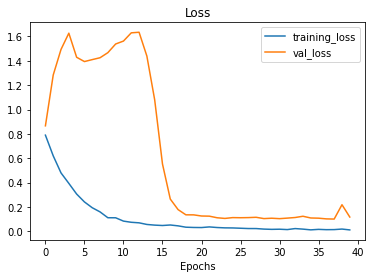

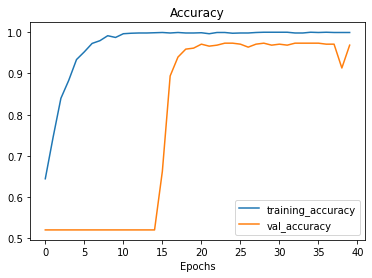

In [10]:
plot_loss_curves(history)

[[9.4773775e-01 5.2262273e-02]
 [9.9946934e-01 5.3066248e-04]
 [3.2781390e-04 9.9967217e-01]
 [2.3976794e-02 9.7602320e-01]]


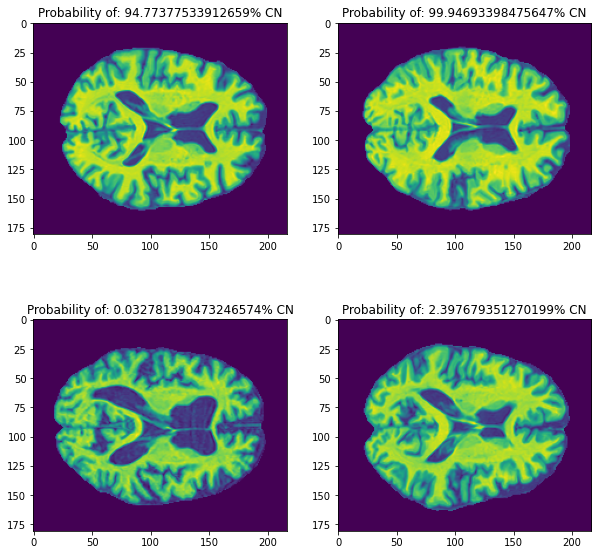

In [11]:
final_test_X = []
path = "../input/adni-data/ADNI_PROCESSED"
for index in X_test_index:
    file = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii'
    img_n_mmni = nib.load(file)
    img_data = cut_2D_i(img_n_mmni, "z", 86)
    #img_data = np.transpose(img_data, (0, 2, 1))/255.0
    final_test_X.append(img_data)
final_test_X = np.array(final_test_X)
y_pred = model_2.predict(final_test_X)
print(y_pred)
plt.figure(figsize=(10,10))
for n in range(len(X_test_index)):
    ax = plt.subplot(2,2,n+1)
    plt.imshow(final_test_X[n])
    title = "Probability of: " + str(y_pred[n][0]*100) + "% CN"
    plt.title(title)

### 3D implementation of classification model
- Creation of an auto-encoder model and an only encoder model.
- compilation of the model using adam optimizer, and binary_crossentropy loss.
- fiting the model using GPU if it exists.

In [ ]:
def create_Unet_model3D(input_size, depth=5, padding='valid'):
    inputs = Input(shape=input_size)
    x = inputs
    num_filters = 64
    encode_layers_list = []
    for i in range(depth):
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding, activation='relu')(x)
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding, activation='relu')(x)
        if i != depth - 1:
            encode_layers_list.append(x)
            x = MaxPooling3D(pool_size=(2,2,2), strides=2)(x)
            num_filters *= 2
    

    for i in range(depth - 1):
        x = UpSampling3D()(x)
        x = Conv3D(filters=num_filters, kernel_size=(2,2,2), activation='relu', padding='same')(x)
        #cropping
        encoder_shape = encode_layers_list[depth - 2 - i].shape
        decoder_shape = x.shape
        shape_diff = (encoder_shape[1] - decoder_shape[1], encoder_shape[2] - decoder_shape[2], encoder_shape[3] - decoder_shape[3])
        xshape_diff = shape_diff[0] // 2
        yshape_diff = shape_diff[1] // 2
        zshape_diff = shape_diff[2] // 2
        if shape_diff[0] % 2 != 0:
            xshape_diff = (shape_diff[0] // 2, shape_diff[0] // 2 + 1)
        if shape_diff[1] % 2 != 0:
            yshape_diff = (shape_diff[1] // 2, shape_diff[1] // 2 + 1)
        if shape_diff[2] % 2 != 0:
            zshape_diff = (shape_diff[2] // 2, shape_diff[2] // 2 + 1)
        croped_layer = Cropping3D(cropping=(xshape_diff, yshape_diff, zshape_diff))(encode_layers_list[depth - 2 - i])

        x = concatenate([croped_layer, x])
        num_filters /= 2
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding, activation='relu')(x)
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding, activation='relu')(x)

    outputs = Conv3D(filters=2, kernel_size=(1,1,1))(x)
        
    return Model(inputs, outputs)

def create_Unet_model3D_encoder(input_size, depth=5, padding='valid', nb_class=2):
    inputs = Input(shape=input_size)
    x = inputs
    num_filters = 64
    for i in range(depth):
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        if i != depth - 1:
            x = MaxPooling3D(pool_size=(2,2,2), strides=2)(x)
            num_filters *= 2
    
    x = GlobalAveragePooling3D()(x)

    x = Dropout(0.5)(x)
    outputs = Dense(nb_class, activation='sigmoid')(x)

    return Model(inputs, outputs)

In [ ]:
model_3 = create_Unet_model3D_encoder(X_data_3D[0].shape, depth=2)
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_3.summary()

In [ ]:
from sklearn.model_selection import train_test_split

X_train_3D, X_val_3D, Y_train_3D, Y_val_3D = train_test_split(X_data_3D, Y_data_3D, test_size=0.25,random_state=42)
print("Data splited")

In [ ]:
history = model_3.fit(X_train_3D, Y_train_3D, epochs= 50, batch_size=8, validation_data=(X_val_3D, Y_val_3D))

In [ ]:
plot_loss_curves(history)